In [1]:
# Copyright © 2021 LEADERG Inc. All rights reserved. Please keep it private. Publish to internet is not allowed. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
#from xgboost import XGBClassifier
import xgboost
from xgboost import plot_importance
import pickle
import sys
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
%matplotlib inline

In [4]:
# parameters
train_input_filename = "data/stock/train_input.csv"
model_filename = "data/stock/model/model.sav"
scaler_filename = "data/stock/model/scaler.pkl"
train_output_filename = "data/stock/train_output.csv"
modelEstimators = 1000

In [5]:
# read csv
dataset_org = pd.read_csv(train_input_filename)
dataset = dataset_org.copy()

In [6]:
# drop the first column
dataset = dataset.drop(dataset.columns[[0]],axis=1)

In [7]:
for i in dataset.columns:
    # deal with stock volume which has ','
    dataset[i] = dataset[i].replace(',', '', regex=True)
    dataset[i] = pd.to_numeric(dataset[i], errors='coerce')

In [8]:
# if dataset contains Nan, then exit
if dataset.isnull().values.sum() > 0:
    listna = np.argwhere(dataset.isnull().values).tolist()
    for listna_list in listna:
        print("ERROR!Value (%d, %d) is empty!" %(int(listna_list[0]) + 2,int(listna_list[1]) + 2))
    sys.exit(1)

In [9]:
X = dataset.iloc[:,0:-1]
#X = dataset_norm.iloc[:,0:-1]
print("Shape of X = ", X.shape)

Shape of X =  (506, 1400)


In [10]:
Y = dataset.iloc[:,-1]
#Y = dataset_norm.iloc[:,-1]
print("Shape of Y = ", Y.shape)

Shape of Y =  (506,)


In [11]:
# normalization
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

scaler = MinMaxScaler()

# fit scaler on the training dataset
scaler.fit(X)

# transform the training dataset
X_norm = scaler.transform(X)

# save the scaler
dump(scaler, open(scaler_filename, 'wb'))

In [12]:
# regression model
regr = xgboost.XGBRegressor(n_estimators = modelEstimators, random_state=0, objective='reg:squarederror')
regr.fit(X_norm, Y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [13]:
# save the model
pickle.dump(regr, open(model_filename, 'wb'))

In [14]:
# calculate predictions
predictions = regr.predict(X_norm)

In [15]:
# print RMSR, R2
print('\n均方根誤差: %.5f' %( np.sqrt(metrics.mean_squared_error(Y, predictions))))
print('R 平方值: %.5f' %( metrics.r2_score(Y, predictions)))


均方根誤差: 0.00036
R 平方值: 1.00000


In [16]:
# restore to original predictions
#Y_org = Y*(data_max[-1]-data_min[-1]) + data_mean[-1]
Y_org = Y


predictions_org = predictions.copy()
#predictions_org = predictions*(data_max[-1]-data_min[-1]) + data_mean[-1]
predictions_org = pd.DataFrame(predictions_org, columns=['prediction'])

In [17]:
# save predictions to result.csv
dataset_prediction = pd.concat([dataset_org, predictions_org], axis=1)
dataset_prediction.to_csv(train_output_filename, index=False)

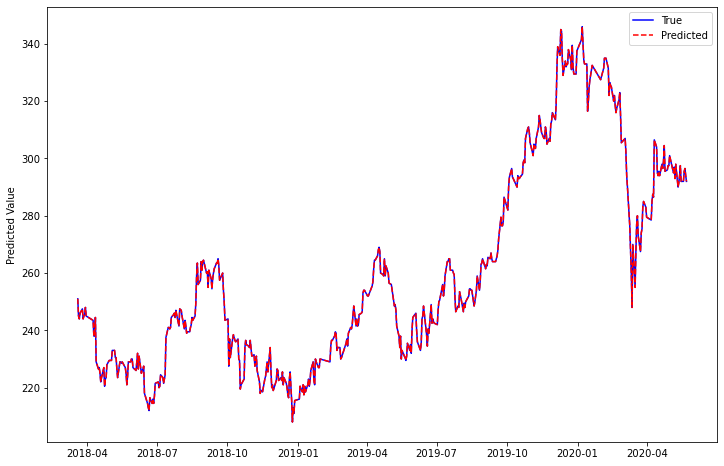

In [18]:
# show results
plt_x = dataset_org['date']
plt_x = pd.to_datetime(plt_x, format='%Y-%m-%d') 

plt.subplots(figsize=(12,8))
#line_1 = plt.plot(dataset_norm.index, Y_org, 'b', label='True')
#line_2 = plt.plot(dataset_norm.index, predictions_org, 'r--', label='Predicted')
line_1 = plt.plot(plt_x, Y_org, 'b', label='True')
line_2 = plt.plot(plt_x, predictions_org.iloc[:,-1], 'r--', label='Predicted')
plt.ylabel('Predicted Value')
#plt.xlabel('Index')
plt.legend()
plt.show()  

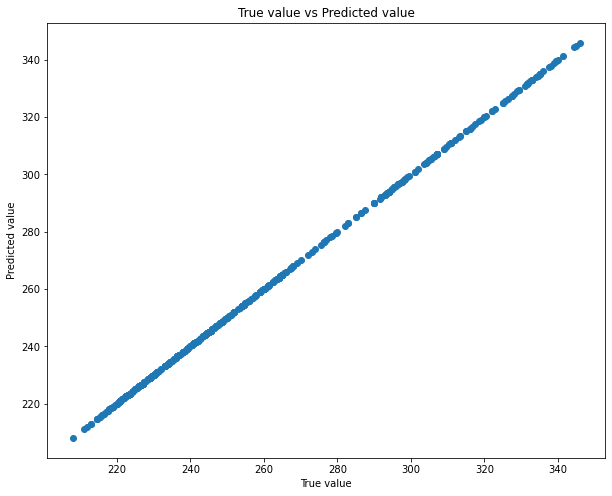

In [19]:
# real vs predicted scatter plot
plt.subplots(figsize=(10,8))
plt.scatter(Y_org, predictions_org)
plt.ylabel('Predicted value')
plt.xlabel('True value')
plt.title("True value vs Predicted value")
plt.show() 

In [20]:
# feature importance
data = [regr.feature_importances_]
df_index = dataset.keys()
columns = df_index[0:len(df_index)-1]
df = pd.DataFrame(data,columns=columns,index = ["feature importances"],dtype=float)

df_sort = df.sort_values(by="feature importances",axis=1, ascending=False)
# settings to display all columns
pd.set_option("display.max_columns", None)
# display the dataframe head
df_sort.head()
df_sort

,open.279,high.279,low.279,close.277,low.275,close.279,close.50,close.39,low.254,low.255,close.269,low.13,low.71,high.246,high.260,high.32,close.263,high.271,open.210,high.79,close.247,open.141,high.48,close.77,low.15,low.112,close.159,high.74,open.265,close.224,close.122,high.9,close.160,open.42,open.160,high.1,low.253,low.258,open.171,high.224,close.266,close.144,open.41,high.225,high.176,open.238,low.245,high.168,low.224,high.255,low.171,close.147,high.203,low.203,low.154,close.74,low.223,low.220,close.212,open.118,open.170,low.88,low.27,high.198,low.116,high.157,open.258,close.258,low.61,low.135,open.161,low.16,low.241,open.26,open.146,high.208,high.129,low.136,volume.111,low.121,close.155,low.29,high.12,open.52,low.233,open.254,low.132,volume.235,volume.238,volume.100,high.250,high.62,close.19,open.165,open.89,volume.198,open.271,high.133,close.108,high.57,high.128,open.66,high.73,close.53,open.19,volume.36,close.192,open.150,volume.237,low.5,high.146,high.77,high.102,volume.181,volume.222,volume.65,volume.158,volume.184,open.12,high.136,low.242,open.226,low.212,volume.55,volume.248,open.43,open.173,volume.241,volume.131,volume.64,low.265,volume.279,open.39,volume.47,open.175,volume.218,open.14,high.82,volume.240,low.267,low.85,volume.175,volume.154,volume.277,volume.169,volume.162,open.235,open.195,volume.92,open.257,volume.27,volume.80,volume.151,volume.118,close.104,volume.221,volume.203,volume.56,open.15,low.210,volume.216,open.81,open.219,close.88,volume.62,volume.271,volume.95,open.256,high.130,open.112,volume.256,close.222,open.28,volume.10,volume.60,volume.176,high.124,volume.77,open.1,volume.167,volume.234,low.57,volume.259,volume.186,volume.205,open.65,open.145,close.124,open.116,low.140,volume.72,volume.269,close.37,volume.127,volume.54,open.68,low.152,volume.178,volume.44,volume.220,open.180,volume.245,volume.6,volume.112,volume.87,volume.126,volume.33,high.123,close.17,volume.138,low.264,volume.251,high.45,volume.149,volume.171,open.3,volume.239,volume.230,volume.110,volume.116,volume.274,high.171,volume.161,open.156,high.222,high.119,volume.22,volume.170,close.44,close.197,volume.155,volume.97,high.7,high.231,volume.15,low.142,volume.148,volume.70,open.36,close.207,high.155,volume.150,volume.194,high.104,open.2,volume.74,volume.182,volume.71,close.65,volume.136,volume.217,volume.61,close.30,volume.73,volume.244,volume.78,open.225,volume.41,low.266,volume.84,open.149,volume.264,close.75,volume.1,volume.58,close.25,volume.211,volume.144,open.108,volume.173,volume.40,close.218,volume.4,volume.224,volume.86,close.95,volume.135,volume.278,volume.179,volume.214,close.69,volume.180,volume.229,open.4,volume.254,low.160,high.242,volume.49,close.109,volume.89,volume.257,close.24,volume.228,open.6,volume.113,open.22,close.242,close.139,close.36,open.131,volume.7,volume.11,volume.193,volume.85,high.140,volume.76,volume.57,volume.130,volume.128,close.163,volume.31,volume.137,volume.236,volume.106,close.23,volume.270,volume.165,close.4,volume.246,volume.187,close.83,open.139,low.106,high.193,volume.26,volume.227,volume.52,close.126,low.101,close.3,volume.3,open.143,volume.166,high.121,volume.197,close.177,volume.156,low.138,volume.108,close.191,volume.188,volume.96,high.88,volume.129,close.80,volume.2,open,low.222,volume.19,volume.123,volume.5,volume.42,low,volume.20,volume.225,volume.25,volume.34,volume.189,high.158,high.150,low.123,volume.145,volume.67,volume.16,volume.66,volume.82,close.64,volume.159,volume.13,volume.233,volume.272,volume.163,close.84,volume.141,volume.18,high.4,volume.53,high.105,volume.48,volume.75,high.49,volume.38,low.47,high.212,close.143,open.138,volume.139,volume.88,low.83,volume.107,close,volume.9,volume.125,close.94,volume.45,volume.83,volume.98,volume.143,volume.157,volume.105,close.129,open.216,volume.191,low.9,close.136,volume.199,volume.120,volume.51,open.48,volume.93,open.190,close.66,volume.68,volume.206,volume.231,low.86,open.159,volume.243,volume.21,volume.219,volume.30,volume.39,volum

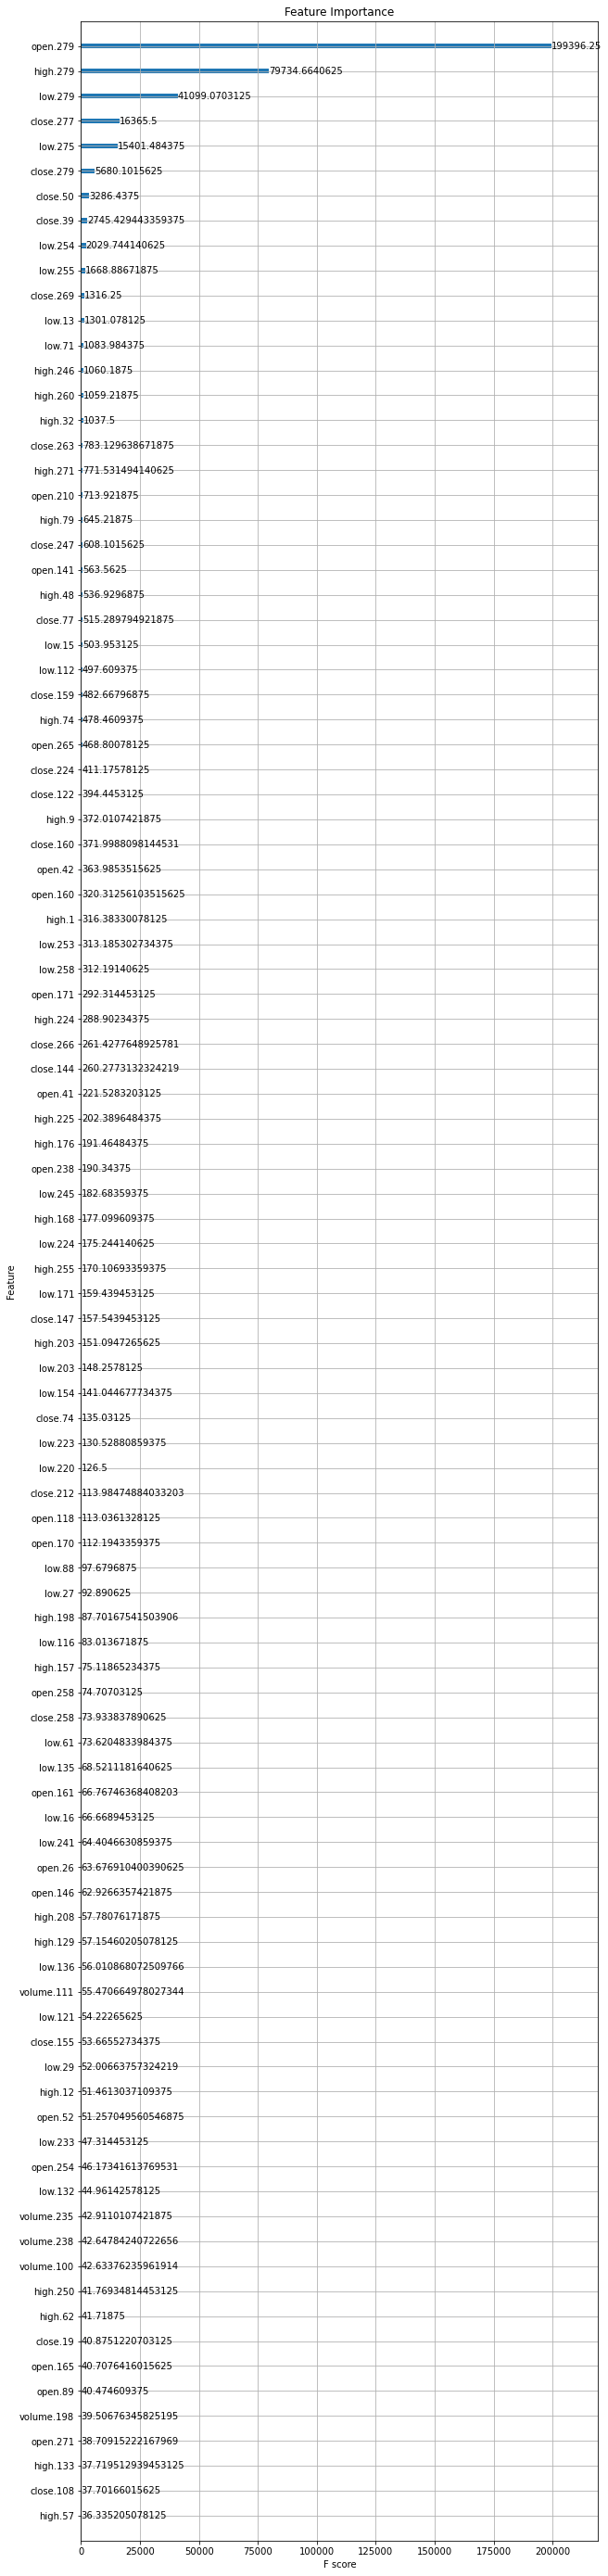

In [21]:
# plot feature importance
df_index = dataset.keys()
regr.get_booster().feature_names =  df_index[0:len(df_index)-1].tolist()

max_num_features = 100
if max_num_features > df_sort.shape[1]:
    max_num_features = df_sort.shape[1]
size_h = int(max_num_features * 0.5)
plt.rcParams["figure.figsize"] = (10,size_h)

plot_importance(regr, title='Feature Importance', ylabel='Feature', max_num_features=max_num_features, grid=True, importance_type='gain')# weight, gain, cover
plt.show()